# Stock prediction model

In this notebook will try to build out model that predicts stock price movements with a greater accuracy that simple moving averages 
Due to the limitations of the free version of the polygon.io api, we only have two years of data which heavily limits the accurcay of results.

If you would like to run you own version of this predictor, Update the pred_stock to the stock you are hoping to predict and update stocks with that stock and the 5 closest competitors ( dependent on parameters you may need to exclude competitors as in this example, it lowered accuracy to include them).

## Table of Contents

I. [Import required packages](#irp)<br>
II. [Extract stock prices](#esp)<br>
III. [Missing data](#md)<br>
IV. [Exploritory analysis](#ea)<br>
V. [Auto regression](#ar)<br>
VI. [Excluded Standard deviation](#esd)<br>
VII. [STD vs later trading price](#sltp)<br>
IX. [Pct changes](#pc)<br>
X. [Loss aversion](#la)<br>
XI. [Moving averages and time series analysis](#matsa)<br>
XIV. [Moving Average](#ma)<br>
XV. [Exponential moving average](#ema)<br>
XVI. [Variations of model and adjustments to the data](#vmad)<br>
XVII. [Variance inflation factor](#vif)<br>
XVIII. [Optimal model and metrics](#omm)<br>
XIX. [Final notes](#fn)<br>

## <a class="anchor" id="irp">Part I : Import required packages</a>

In [141]:
import pandas as pd
import numpy as np
import requests
import warnings

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler

import xgboost as xgb

import sys

%matplotlib inline

## <a class="anchor" id="esp">Part II : Extract stock prices</a>

In [142]:
def get_stock_prices(api_key, tckr): 
    '''
    Input 
    api_key - unique key from polgon.io that you get for signing up
    tckr - the stock that values need to be extracted 

    Ouput 
    df - volume, price, open, close, high and low stock prices for the stock for each day for the previous 2 years 
         (2 years is the maxiumum time span for the free trial of polygon.io )
    '''
    url = f'https://api.polygon.io/v2/aggs/ticker/{tckr}/range/1/day/2023-01-19/2025-01-19?apiKey={api_key}'
    
    response = requests.get(url)
    data = response.json()
    
    # Convert the JSON data to a pandas DataFrame
    df = pd.DataFrame(data['results'])
    
    # Convert the timestamp to a readable date format
    df['t'] = pd.to_datetime(df['t'], unit='ms')
    
    # Display the historical data
    return df

In [143]:
# Input your API key for polygon.io
api_key = 'BIf89HTb0NaGQsWozgDr5x1W8GfFC3MH'
# Choose 4 stores that are closest competitors as we can only download 5 a min with the free API 
stocks = ['GLW','APH','DLB','LFUS','ROG']

stock_prices_df = pd.DataFrame([])

for tckr in stocks:
    stock_prices_df_pre = get_stock_prices(api_key, tckr)
    stock_prices_df_pre.columns = [f"{col}_{tckr}" if col != 't' else col for col in stock_prices_df_pre.columns]
    if stock_prices_df.empty:
        stock_prices_df = stock_prices_df_pre
    else:
        stock_prices_df = stock_prices_df.merge(stock_prices_df_pre, on='t', how='outer')

# Stock we wish to predict future sales for 
pred_stock = 'o_GLW'

In [144]:
stock_prices_df.head()

,v_GLW,vw_GLW,o_GLW,c_GLW,h_GLW,l_GLW,t,n_GLW,v_APH,vw_APH,...,h_LFUS,l_LFUS,n_LFUS,v_ROG,vw_ROG,o_ROG,c_ROG,h_ROG,l_ROG,n_ROG
0,3572644.0,35.9463,35.90,35.74,36.44,35.6400,2023-02-03 05:00:00,35034,5825416.0,40.8352,...,272.79,258.4790,5846,415919,145.2770,141.72,146.99,147.120,140.8100,8453
1,4514611.0,35.1156,35.27,35.02,35.41,35.0100,2023-02-06 05:00:00,35884,4533618.0,40.8324,...,267.88,260.5250,4487,742779,152.2657,150.57,149.26,156.560,148.6150,15648
2,5692601.0,35.1262,34.81,35.19,35.35,34.7025,2023-02-07 05:00:00,43333,6542410.0,40.4490,...,271.71,262.5200,5170,604627,148.4731,151.61,150.56,151.610,144.1500,12014
3,4396486.0,35.1859,34.94,35.14,35.43,34.8200,2023-02-08 05:00:00,40266,5225694.0,40.6529,...,273.35,268.3925,6047,276651,150.4542,149.49,150.87,151.880,148.0800,7830
4,3346152.0,35.3058,35.48,35.00,35.91,34.8800,2023-02-09 05:00:00,31341,5260170.0,40.3738,...,277.68,268.3975,4082,365940,150.2499,151.44,149.63,152.165,148.6875,8284


## <a class="anchor" id="md">Part III : Missing data</a>

In [145]:
stock_prices_df.isna().sum().sum()

np.int64(0)

In [146]:
stock_prices_df.isin([np.inf, -np.inf]).sum().sum()

np.int64(0)

In [147]:
# No missing data, all has been pulled through from the API 

### <a class="anchor" id="ea">Part IV : Exploritory analysis</a>

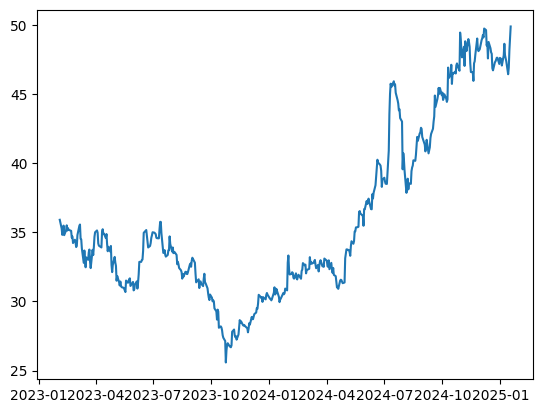

In [148]:
# look at trend over time 
plt.plot(stock_prices_df['t'],stock_prices_df[pred_stock])

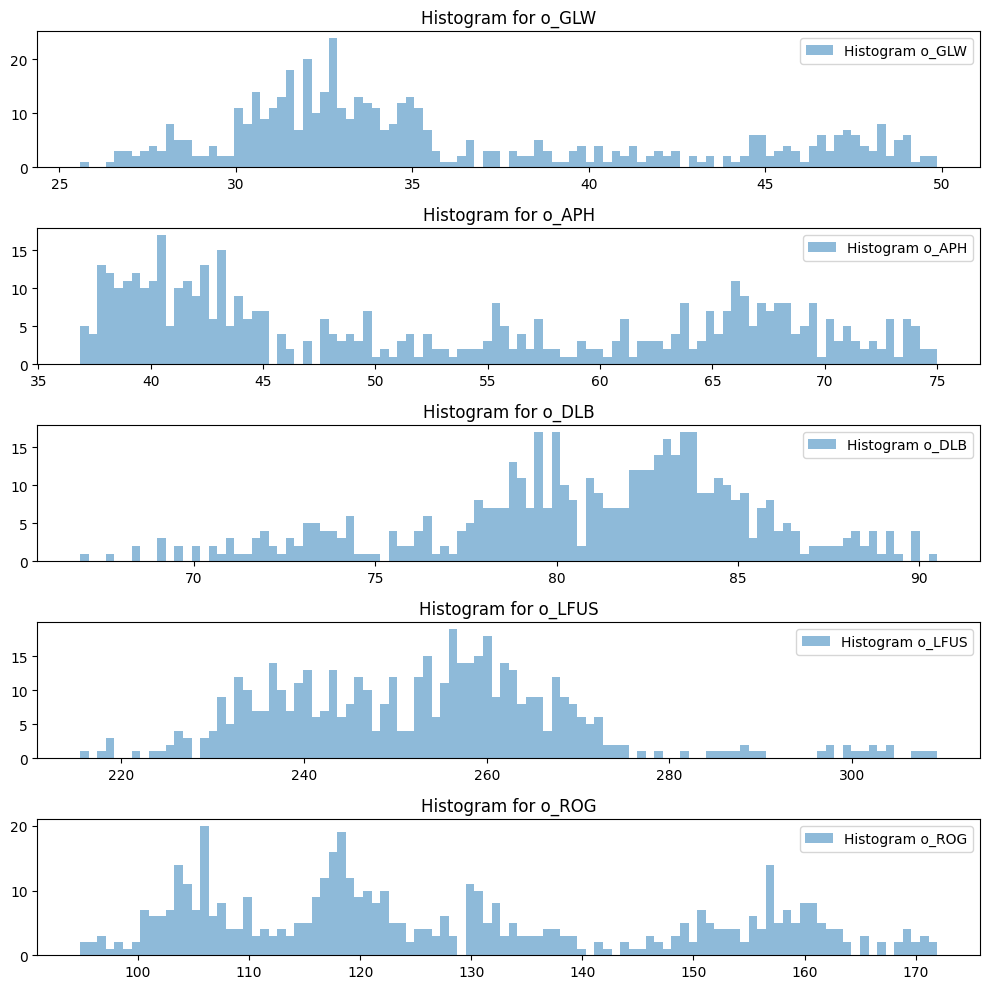

In [149]:
# Most stocks are not normally distributed so make sure methods do not assume this 
fig, axs = plt.subplots(5, 1, figsize=(10, 10))

for i, tckr in enumerate(stocks):
    tckr = 'o_' + tckr 
    axs[i].hist(stock_prices_df[tckr], bins=100, alpha=0.5, label=f'Histogram {tckr}')
    axs[i].set_title(f'Histogram for {tckr}')
    axs[i].legend()

plt.tight_layout()
plt.show()

## <a class="anchor" id="ar">Part V : Auto regression</a>

In [150]:
def autocorrelation_check(df, target_col, col, min_lag=5, max_lag=50):
    ''' 
    Input 
    df - stock prices data of stocks and competitors
    target_col - the prediction stock
    col - column to check for autocorrelation
    min_lag - minimum number of lags
    max_lag - maximum number of lags 

    Output 
    correlation_df - Correlation up to the maximum lag between the prediction column and the input column 
    '''

    correlations = [
        {'lag': lag, 'correlation': df[target_col].corr(df[col].shift(lag))} for lag in range(min_lag, max_lag + 1)
    ]
    
    return pd.DataFrame(correlations)

def generate_top_correlations(df, target_col=pred_stock, min_lag=5, max_lag=50):
    ''' 
    Input 
    df - stock prices data of stocks and competitors
    target_col - the prediction stock
    col - column to check for autocorrelation
    min_lag - minimum number of lags
    max_lag - maximum number of lags 

    Output 
    top_correlations - Top correlations between each lagged column and the target column 
    '''

    all_correlations = []
    for col in df.columns:
        if col == 't':
            continue
        correlation_df = autocorrelation_check(df, target_col, col, min_lag, max_lag)
        correlation_df['column'] = col
        all_correlations.append(correlation_df[correlation_df['correlation'].abs() == correlation_df['correlation'].abs().max()])
    
    all_correlations_df = pd.concat(all_correlations)
    
    # Select only the relevant columns
    top_correlations = all_correlations_df[['column', 'lag', 'correlation']]
    
    return top_correlations

In [151]:
top_corr_columns = generate_top_correlations(stock_prices_df,max_lag = 28* 6 )
top_corr_columns

,column,lag,correlation
107,v_GLW,112,0.340184
0,vw_GLW,5,0.980569
0,o_GLW,5,0.978794
0,c_GLW,5,0.980898
0,h_GLW,5,0.979661
0,l_GLW,5,0.980154
75,n_GLW,80,0.350528
36,v_APH,41,0.314871
112,vw_APH,117,0.949309
112,o_APH,117,0.948898


Check to see if correlations match up and are not just anomalies 

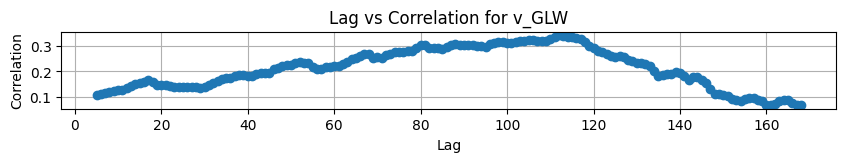

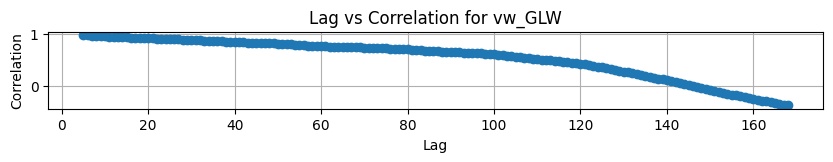

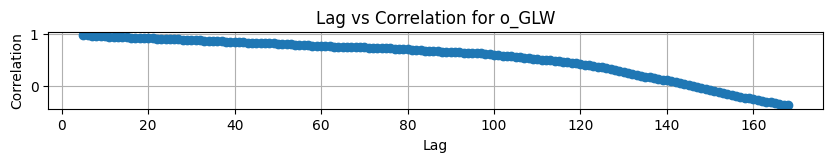

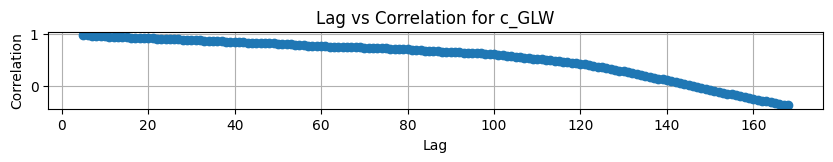

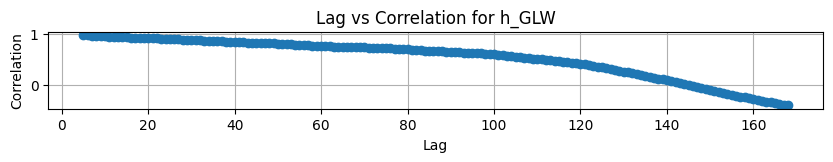

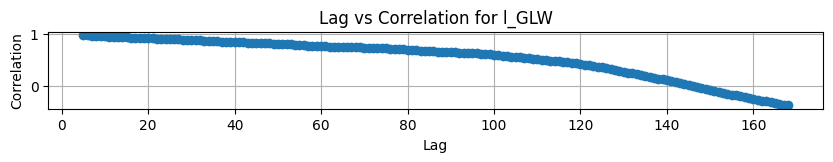

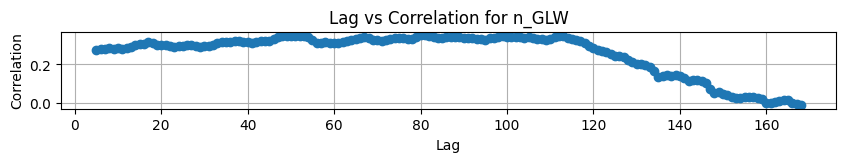

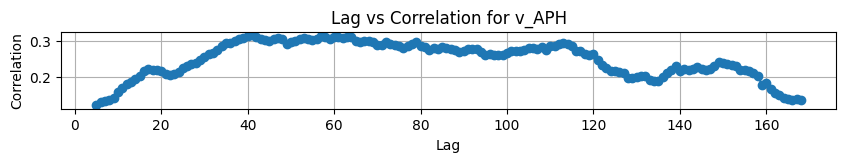

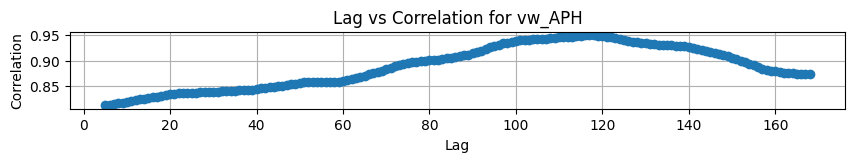

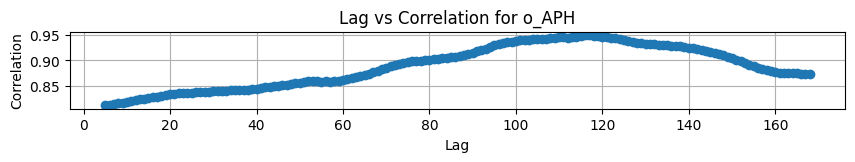

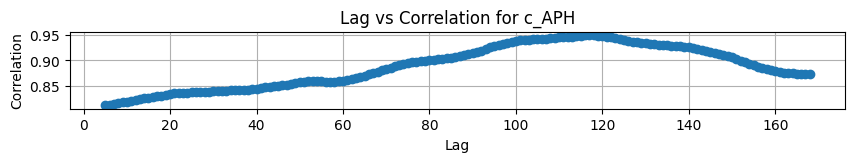

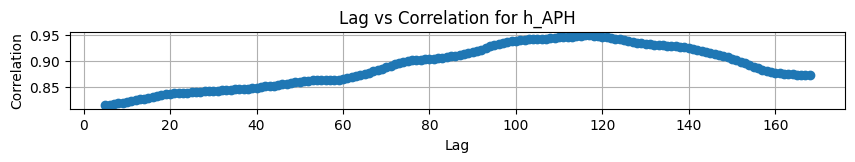

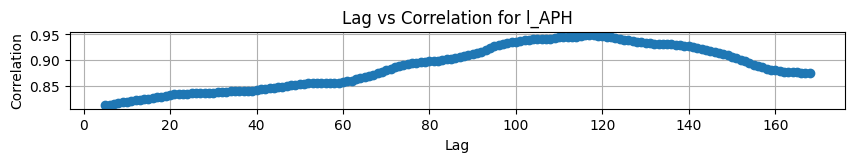

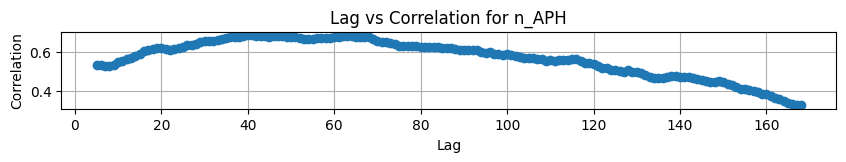

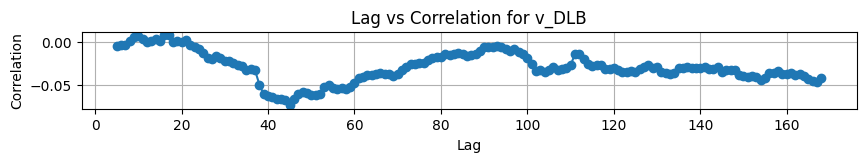

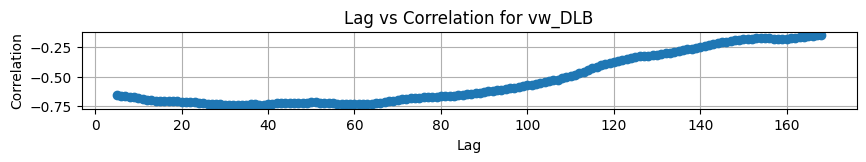

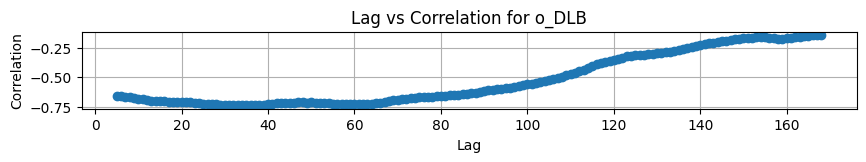

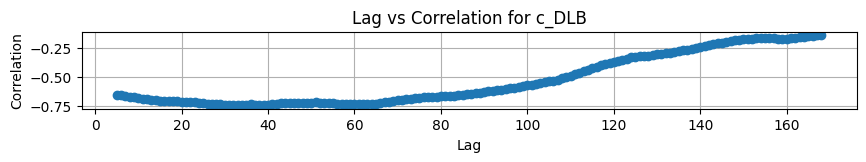

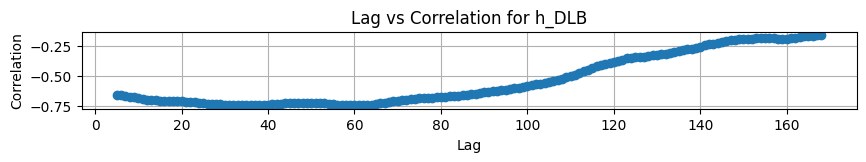

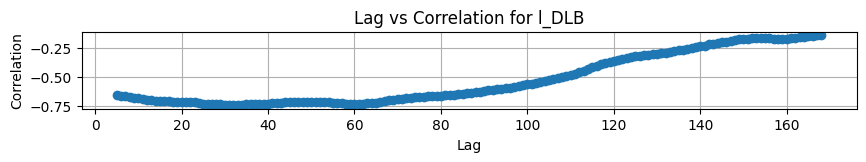

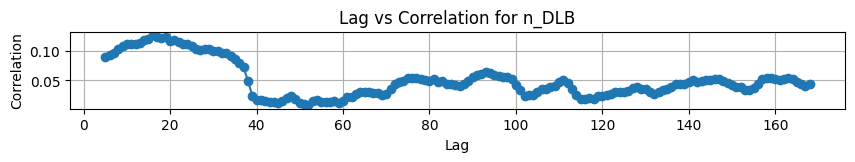

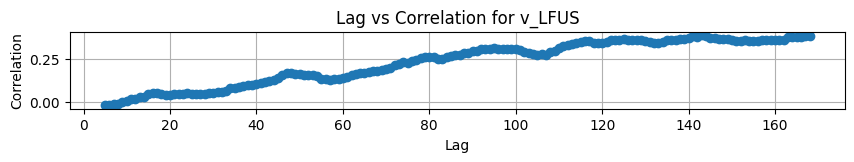

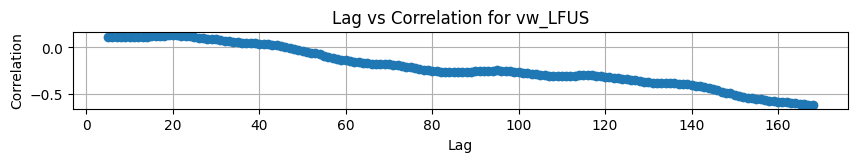

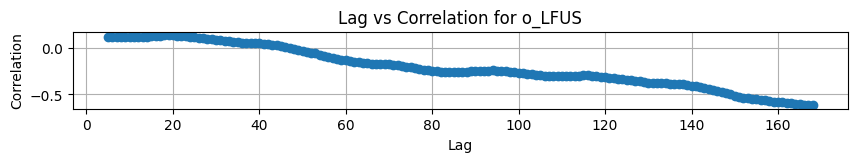

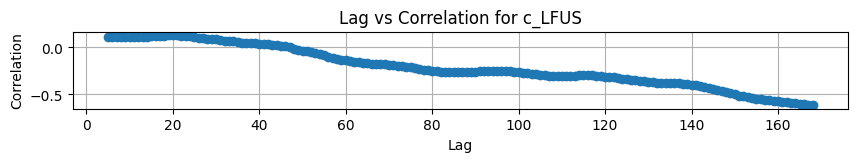

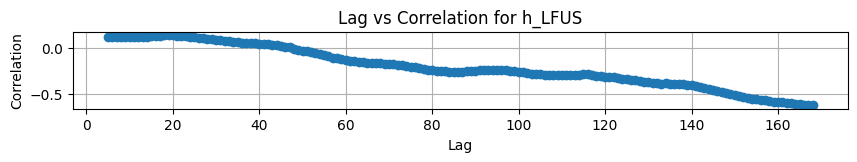

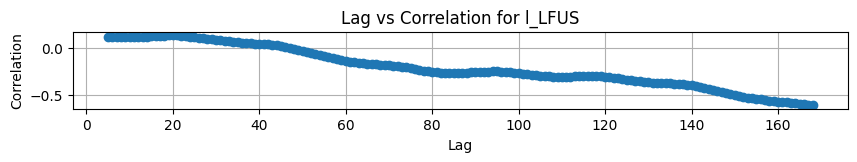

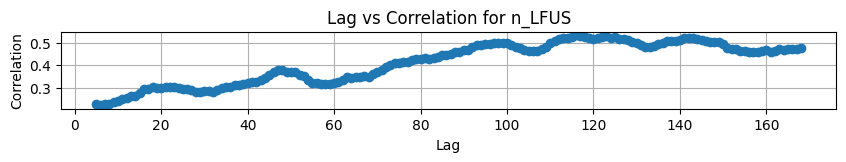

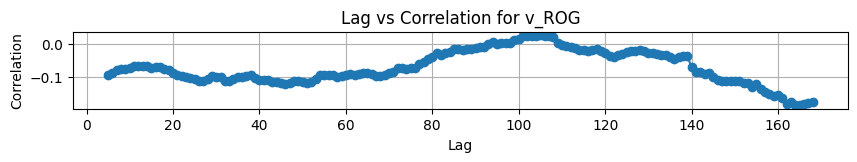

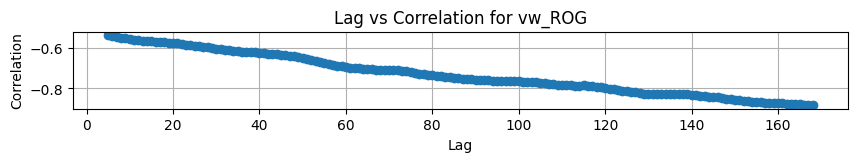

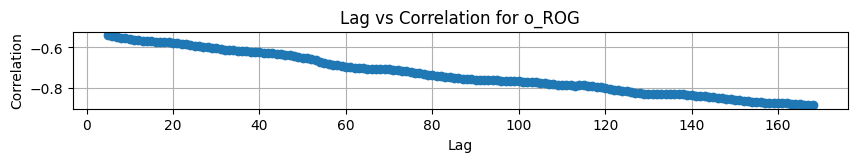

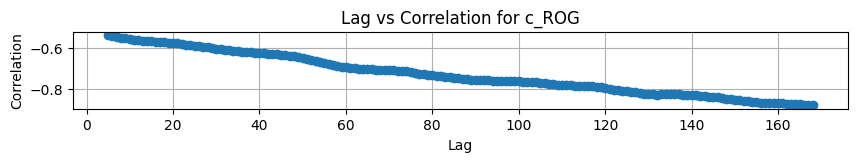

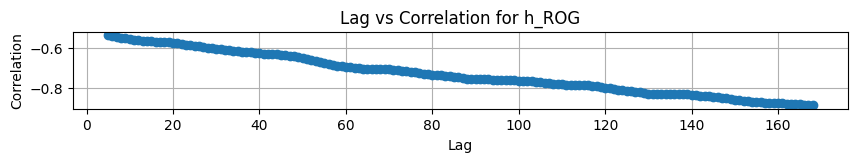

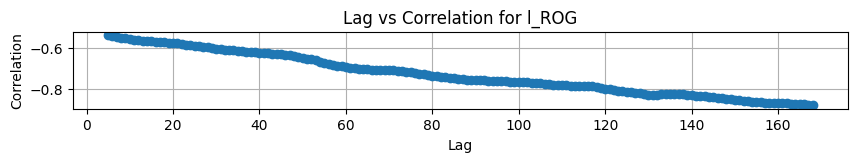

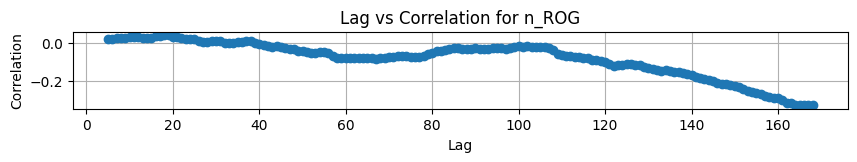

In [152]:
# 
def plot_correlations(df, target_col=pred_stock, min_lag=5, max_lag=50):
    for col in df.columns:
        if col == 't' :
            continue
        correlation_df = autocorrelation_check(df, target_col, col, min_lag, max_lag)
        plt.figure(figsize=(10, 1))
        plt.plot(correlation_df['lag'], correlation_df['correlation'], marker='o')
        plt.title(f'Lag vs Correlation for {col}')
        plt.xlabel('Lag')
        plt.ylabel('Correlation')
        plt.grid(True)
        plt.show()

# Only a few double peaks so maxiumum can be used
plot_correlations(stock_prices_df,max_lag = 28 * 6)

Lag columns and understand how much of the varaition can be explained by the minimum number of columns with PCA

In [153]:
lagged_df = pd.DataFrame()

for index, row in top_corr_columns.iterrows():
    column_name = row['column']
    lag_amount = row['lag']
    
    # Shift the column by the specified lag amount
    lagged_column = stock_prices_df[column_name].shift(lag_amount)
    
    # Add the lagged column to the new dataframe
    lagged_df[column_name] = lagged_column

# Drop rows with NaN values resulting from the lagging process
lagged_df.dropna(inplace=True)

# 99% of autocorrelation variation done by 2 previous columns 
pca = PCA(n_components=0.99)
pca_result = pca.fit_transform(lagged_df)

# Convert PCA result to a dataframe
pca_df = pd.DataFrame(pca_result)
pca_df

,0,1,2
0,5.033655e+05,-2.567553e+06,-160859.714526
1,-6.258486e+05,-7.694401e+05,-39974.388498
2,-1.783666e+06,-2.609416e+06,641991.092714
3,-2.348819e+06,-2.712293e+06,-49246.877512
4,-1.412655e+06,-9.020164e+04,-75616.300307
...,...,...,...
318,3.123551e+06,-2.358721e+06,-247744.125869
319,1.720461e+06,1.003271e+06,-97430.217398
320,1.468877e+06,-1.401744e+06,-238675.963955
321,1.899937e+06,5.174574e+04,-153583.296797


In [154]:
# Create function for processing data later 

def comp_corr_pca(df, target_col, min_lag=5, max_lag=50):

    # Generate top correlations
    top_corr_columns = generate_top_correlations(df, target_col, min_lag, max_lag)
    
    # Create a new DataFrame for lagged columns
    lagged_df = pd.DataFrame()
    for _, row in top_corr_columns.iterrows():
        column_name = row['column']
        lag_amount = row['lag']
        lagged_df[column_name] = df[column_name].shift(lag_amount)
    lagged_df.dropna(inplace=True)

    # Ensure only numeric columns are used for PCA
    numeric_lagged_df = lagged_df.select_dtypes(include=['number'])

    # Perform PCA to reduce dimensionality
    pca = PCA(n_components=0.99)
    pca_result = pca.fit_transform(numeric_lagged_df)
    pca_df = pd.DataFrame(pca_result, index=lagged_df.index)

    # Add the PCA columns to the original df
    for i in range(pca_df.shape[1]):
        df[f"Competitor_PCA_{i+1}"] = pca_df.iloc[:, i]

    return df

### Excluded Standard deviation
Later on it may be beneficial to exclude large fluctuation in stock 

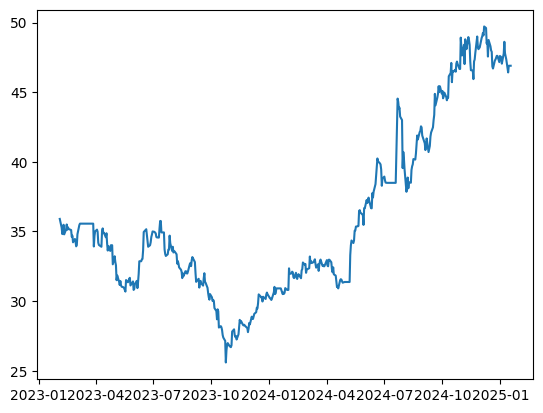

In [155]:
stock_prices_df_plot = stock_prices_df.copy()

# Predicting 5 days into the future so use rolling 5 days standerd deviation 
stock_prices_df_plot[pred_stock + '_std'] =  stock_prices_df_plot[pred_stock].rolling(window=20).std()

# Initialize the last valid value
last_valid_value = stock_prices_df_plot.loc[0, 'o_GLW']

# Create a new column 'o_GLW_no_dev' and copy the original 'o_GLW' values
stock_prices_df_plot['o_GLW_no_dev'] = stock_prices_df_plot['o_GLW']

# Forward fill the previous stock price when the magnitude of the deviation is greater than a threshold
for i in range(1, len(stock_prices_df_plot)):
    threshold = 2 * stock_prices_df_plot.loc[i, 'o_GLW_std']  # Update threshold based on the most recent std
    if abs(stock_prices_df_plot.loc[i, 'o_GLW'] - last_valid_value) > threshold:
        stock_prices_df_plot.loc[i, 'o_GLW_no_dev'] = last_valid_value
    else:
        last_valid_value = stock_prices_df_plot.loc[i, 'o_GLW']

plt.plot(stock_prices_df_plot['t'] ,stock_prices_df_plot['o_GLW_no_dev'])

In [156]:
# Changed to function so can possibly be implemented in the end to improve accuracy 
def remove_deviation(df, target_column):
    

    # Calculate rolling standard deviation
    df[target_column + '_std'] = df[target_column].rolling(window=20).std()

    # Initialize the last valid value
    last_valid_value = df.loc[0, target_column]

    # Create a new column for the adjusted values
    adjusted_column = target_column + '_no_dev'
    df[adjusted_column] = df[target_column]

    # Forward fill the previous stock price when the magnitude of the deviation is greater than a threshold
    for i in range(1, len(df)):
        threshold = 2 * df.loc[i-1, target_column + '_std']  # Update threshold based on the most recent std
        if abs(df.loc[i, target_column] - last_valid_value) > threshold:
            df.loc[i, adjusted_column] = last_valid_value
        else:
            last_valid_value = df.loc[i, target_column]

    return df

## <a class="anchor" id="sltp">Part VII : STD vs later trading price</a>

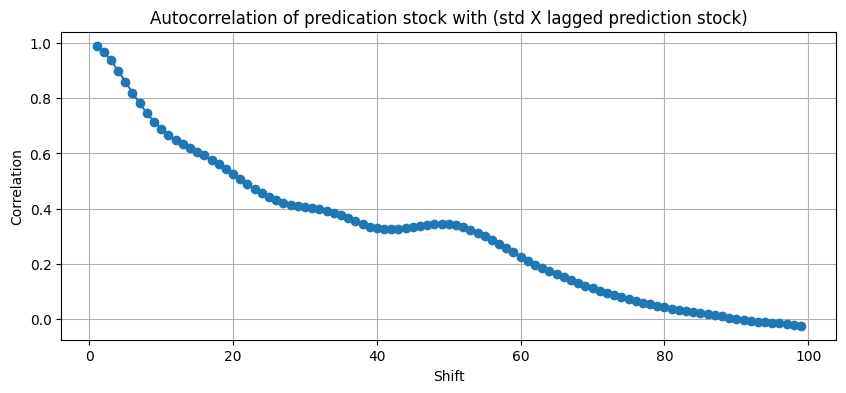

In [177]:
shifts = range(1, 100)
correlations = []

for shift in shifts:
    shifted_column_o_GLW = stock_prices_df_plot['o_GLW'].shift(-shift)
    shifted_column_o_GLW_std = stock_prices_df_plot['o_GLW_std'].shift(-shift)
    
    combined_df = pd.DataFrame({
        'product': stock_prices_df_plot['o_GLW'] * stock_prices_df_plot['o_GLW_std'],
        'shifted_product': shifted_column_o_GLW * shifted_column_o_GLW_std
    }).dropna()
    
    correlation = np.corrcoef(combined_df['product'], combined_df['shifted_product'])[0, 1]
    correlations.append(correlation)

# Plotting the results
plt.figure(figsize=(10, 4))
plt.plot(shifts, correlations, marker='o')
plt.title('Autocorrelation of predication stock with (std X lagged prediction stock)')
plt.xlabel('Shift')
plt.ylabel('Correlation')
plt.grid(True)
plt.show()

Peaks at 47 days shows this may be a usefull metric to add

## <a class="anchor" id="pc">Part IX : Pct changes</a>

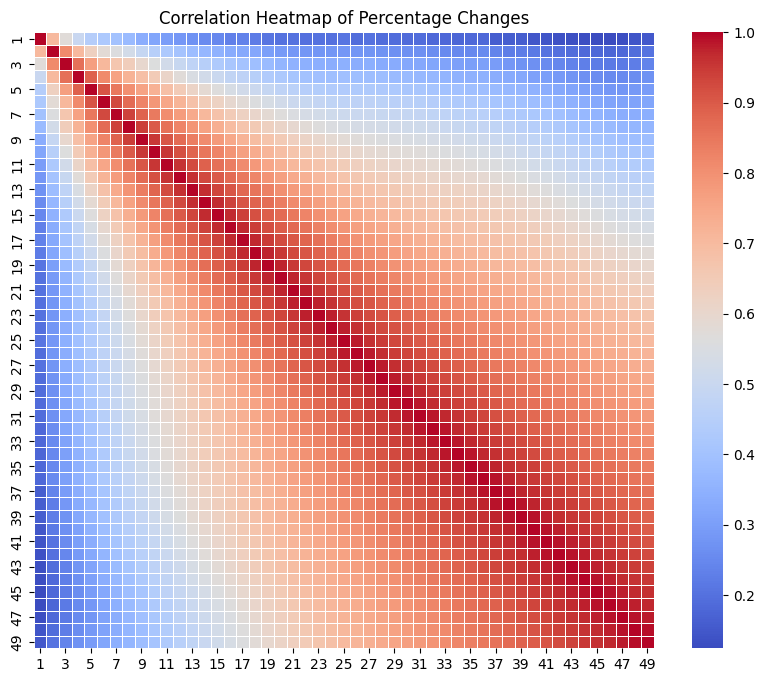

In [158]:
# Create the correlation matrix of percentage changes
pct_change_corr_df = pd.DataFrame([])

for i in range(1, 50):
    pct_change_df = pd.DataFrame(stock_prices_df[pred_stock].pct_change(-i))
    pct_change_df.columns = [str(i)]
    pct_change_corr_df = pd.concat([pct_change_corr_df, pct_change_df], axis=1)

corr_matrix = pct_change_corr_df.corr()

# Generate a heatmap with seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', linewidths=.5)
plt.title('Correlation Heatmap of Percentage Changes')
plt.show()

In [159]:
# Introduce on the most recent pct changes to the data
# We start to see very low correlations after 20 days to this will be the max 

def pct_change(df,target_col):
    '''
    Input 
    df - Stock dataframe
    target_col - target column you wish to get pct changes from

    Ouput
    df - original data frame with pct changes for 1,5,10 and 20 days 

    '''

    df[target_col + '_1_day_pct_chng'] = df[target_col].pct_change(-1)
    df[target_col + '_5_day_pct_chng'] = df[target_col].pct_change(-5)
    df[target_col + '_10_day_pct_chng'] = df[target_col].pct_change(-10)
    df[target_col + '_20_day_pct_chng'] = df[target_col].pct_change(-20)

    return df

## <a class="anchor" id="la">Part X : Loss aversion</a>
- Works on the percent change to identify the fact that dips in stock price are seen as worse than gains 

In [160]:
def loss_aversion_change(df, target_col):
    '''
    Input 
    df - Stock dataframe
    target_col - target column you wish to get pct changes from

    Ouput
    df - original data frame with the loss aversion function equation applied 

    '''

    def loss_aversion_function(x, alpha=0.88, beta=0.88, lambda_=2.5):
        if x >= 0:
            return x ** alpha
        else:
            return -lambda_ * (-x) ** beta
    
    df['loss_averse_' + target_col] = df[target_col].apply(lambda x: loss_aversion_function(x))

    return df

## Moving averages and time series analysis
### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Set up functions for this 

In [178]:
def calculate_mse(df, window, prediction_days, method='MA'):
    '''
    Input 
    df - Stock dataframe
    target_col - period of time of which the moving average is calcualted over
    method - MA for moving average or EMA 

    Ouput
    df - original data frame with the loss aversion function equation applied 

    '''

    df = df.copy() 
    
    if method == 'MA':
        df['average'] = df[pred_stock].rolling(window=window).mean()
    elif method == 'EMA':
        df['average'] = df[pred_stock].ewm(span=window, adjust=False).mean()
    else:
        raise ValueError("Method must be 'MA' or 'EMA'")
    
    
    mse_list = []
    
    for i in range(len(df) - window - prediction_days + 1):
        actual = df[pred_stock][i + window:i + window + prediction_days].values
        predicted = df['average'][i + window:i + window + prediction_days].values
        mse = mean_squared_error(actual, predicted)
        mse_list.append(mse)
    
    return np.mean(mse_list)

def evaluate_mse(df, max_window=28, prediction_days=5, method='MA'):
    '''
    Input 
    df - Stock dataframe
    max_window - maximum period from the end date of the data of which measure
    prediction_days - rolling window to predict over 
    method - for the calcuate_mse function, calculated with MAE or ma

    Ouput
    results_df - data frame of mean squared error for diffrent window sizes for the moving average specified 
                 (A graph showing the rolling mse will also be displayed as well )

    '''
    results = []

    for window in range(1, max_window + 1):
        mse_list = []
        for start_day in range(len(df) - window - 30, len(df) - window - 5):
            mse = calculate_mse(df.iloc[start_day:], window, prediction_days, method)
            mse_list.append(mse)
        avg_mse = np.mean(mse_list)
        results.append({'window': window, 'mse': avg_mse})

    results_df = pd.DataFrame(results)

    plt.plot(results_df['window'], results_df['mse'])
    plt.xlabel('Window Size')
    plt.ylabel('Mean Squared Error')
    plt.title(f'MSE vs Window Size ({method})')
    plt.show()

    return results_df


## <a class="anchor" id="ma">Part XIV : Moving Average</a>

7 days is best for moving average predictions 

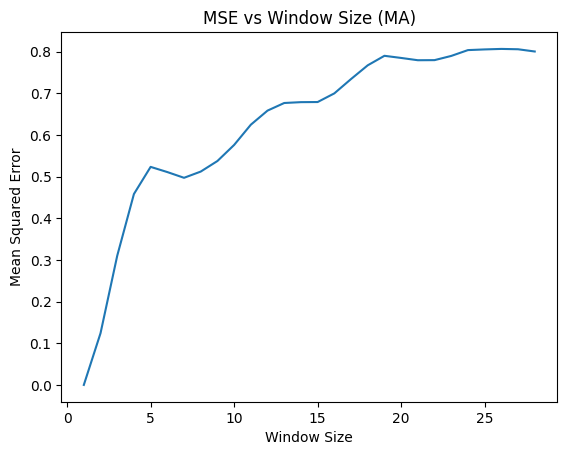

In [179]:
mse_ma = evaluate_mse(stock_prices_df, method='MA')

### Exponential moving average 
### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

EMA is the best methodology due to having the loswest mse

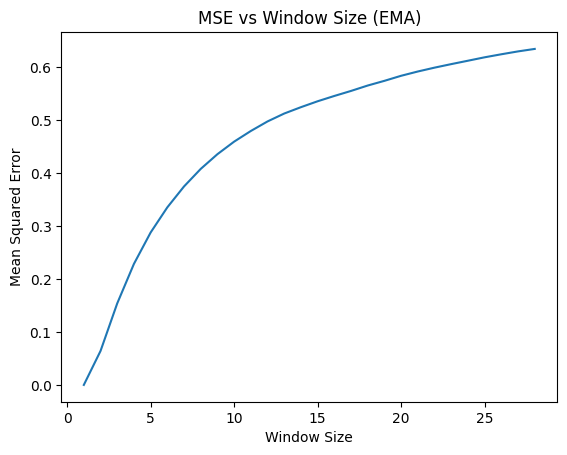

In [163]:
mse_ema = evaluate_mse(stock_prices_df, method='EMA')

- We will use EMA ad 5 days lag due to it having the lowest error overall 
- Greater than 5 days will be used due to predicting 5 days into the future

## <a class="anchor" id="vmad">Part XVI : Variations of model and adjustments to the data</a>

### Add columns to original data frame

In [164]:
stock_prices_model_df = stock_prices_df.copy()

#add stock price with removed deviations
stock_prices_model_df = remove_deviation(stock_prices_model_df,pred_stock)

#Lagged values with competitor stocks and PCA to decrease overfitting 
stock_prices_model_df = comp_corr_pca(stock_prices_model_df,pred_stock)

#Pct_changes
stock_prices_model_df = pct_change(stock_prices_model_df,pred_stock)

#Run loss aversion on the pct changes
for i in ['o_GLW_1_day_pct_chng','o_GLW_5_day_pct_chng','o_GLW_10_day_pct_chng','o_GLW_20_day_pct_chng']:
    stock_prices_model_df = loss_aversion_change(stock_prices_model_df,i)

# Add optimal 5 day rolling average 
stock_prices_model_df[pred_stock + '_EMA'] = stock_prices_model_df[pred_stock].ewm(span=5, adjust=False).mean()

# Add in 47 day lag of std * price as there is a promising correlation between the two 
stock_prices_model_df['o_GLW_std_price'] = stock_prices_model_df['o_GLW_std'].shift(-47) * stock_prices_model_df['o_GLW'].shift(-47)

stock_prices_model_df = stock_prices_model_df.drop(list(stock_prices_df.drop([pred_stock],axis = 1).columns),axis = 1).dropna()

stock_prices_model_df.head()
    

,o_GLW,o_GLW_std,o_GLW_no_dev,Competitor_PCA_1,Competitor_PCA_2,Competitor_PCA_3,o_GLW_1_day_pct_chng,o_GLW_5_day_pct_chng,o_GLW_10_day_pct_chng,o_GLW_20_day_pct_chng,loss_averse_o_GLW_1_day_pct_chng,loss_averse_o_GLW_5_day_pct_chng,loss_averse_o_GLW_10_day_pct_chng,loss_averse_o_GLW_20_day_pct_chng,o_GLW_EMA,o_GLW_std_price
65,31.15,1.284659,31.15,-1.479576e+06,-1.875501e+06,-75377.598214,-0.009224,0.007439,-0.010483,-0.006696,-0.040464,0.013394,-0.045286,-0.030527,31.670793,20.701386
66,31.44,1.262555,31.44,-2.324076e+05,-1.007372e+06,-72872.785956,0.009634,0.020779,-0.005063,-0.015962,0.016817,0.033076,-0.023869,-0.065564,31.593862,21.554459
67,31.14,1.261073,31.14,-1.331633e+06,-3.343352e+05,-200786.958029,0.003545,0.014993,-0.016735,-0.052343,0.006977,0.024820,-0.068349,-0.186439,31.442575,23.071829
68,31.03,1.235826,31.03,-1.049280e+06,-4.281651e+05,-129678.885622,0.001291,-0.015233,-0.002892,-0.055691,0.002868,-0.062921,-0.014581,-0.196893,31.305050,24.824523
69,30.99,1.210921,30.99,2.423478e+05,-1.716954e+06,-91299.282238,0.002264,-0.011483,-0.013372,-0.060624,0.004702,-0.049068,-0.056102,-0.212163,31.200033,25.922080


In [165]:
# Stop skleanr conversion warnings 
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn")

def calculate_metrics(model, train, test, pred_stock):
    '''
    Input 
    model - The model being trained
    train - the time series training data
    test - the time series test data
    pred_stock - the dependent variable to be predicted 

    Ouput
    mse - Mean squared error of the model
    mae - Mean absolute error of the model
    r2 - The varaince explained by the model 

    '''

    model.fit(train.drop(columns=[pred_stock]), train[pred_stock])
    predictions = model.predict(test.drop(columns=[pred_stock]))
    mse = mean_squared_error(test[pred_stock], predictions)
    mae = mean_absolute_error(test[pred_stock], predictions)
    r2 = r2_score(test[pred_stock], predictions)
    return mse, mae, r2

def print_loading_bar(iteration, total, length=50):
    '''
    Input 
    iteration - The number of iterations through 
    total - the total number of iterations to move up to
    lentgh - The length of values printed out

    Ouput
    loading bar that deletes the previous bar and updates with a new one on each iteration.
    '''

    percent = ("{0:.1f}").format(100 * (iteration / float(total)))
    filled_length = int(length * iteration // total)
    bar = '█' * filled_length + '-' * (length - filled_length)
    sys.stdout.write(f'\r|{bar}| {percent}% Complete')
    sys.stdout.flush()

def evaluate_model_for_windows(model_info, df, pred_stock, total_windows=28):
    '''
    Input 
    model_info - model information in a dictionary format, usable for gridsearch 
    df - data frame of stock prices with other modeled metrics 
    pred_stock - stock being predicted 
    total_windows - the total window size to test over 

    Ouput
    Results - 
    '''

    # Load data for specified model
    results = []
    scaler = StandardScaler()
    model = model_info['model']
    grid_search = GridSearchCV(estimator=model, param_grid=model_info['params'], cv=3)
    
    # Run over all windows to find average scores for each 
    for window in range(1, total_windows + 1):
        start_idx = -30 - (window * 5)
        end_idx = start_idx + 5
        train = df.iloc[:start_idx]
        test = df.iloc[start_idx:end_idx]
        
        # Scale the data before prediction
        train_scaled = scaler.fit_transform(train.drop(columns=[pred_stock]))
        test_scaled = scaler.transform(test.drop(columns=[pred_stock]))
        
        # Split into test and train 
        train_scaled = pd.DataFrame(train_scaled, columns=train.drop(columns=[pred_stock]).columns)
        test_scaled = pd.DataFrame(test_scaled, columns=test.drop(columns=[pred_stock]).columns)
        
        # Get the values from test and train 
        train_scaled[pred_stock] = train[pred_stock].values
        test_scaled[pred_stock] = test[pred_stock].values
        
        # Train the data across grid search to get the overall values
        grid_search.fit(train_scaled.drop(columns=[pred_stock]), train_scaled[pred_stock])
        best_model = grid_search.best_estimator_
        
        # Calcculate error metrics for the model 
        mse, mae, r2 = calculate_metrics(best_model, train_scaled, test_scaled, pred_stock)
        results.append({'window': window, 'mse': mse, 'mae': mae, 'r2': r2})
        
        print_loading_bar(window, total_windows)
    
    print() 
    return results

Find optimal model and parameters 

In [166]:
# Total window to measure each model over
total_windows = 28

# Each model defined 
models = {
    'neural_network': {
        'model': MLPRegressor(max_iter=200),
        'params': {
            'hidden_layer_sizes': [(50,), (100,), (50, 50)],
            'activation': ['relu', 'tanh', 'logistic'],
            'solver': ['adam', 'sgd']
        }
    },
    'linear_regression': {
        'model': LinearRegression(),
        'params': {
            'fit_intercept': [True,False]
        }
    },
    'random_forest': {
        'model': RandomForestRegressor(),
        'params': {
            'n_estimators': [50, 100, 200],
            'max_depth': [None, 10, 20, 30]
        }
    },
    'xgboost': {
        'model': xgb.XGBRegressor(),
        'params': {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 5, 7]
        }
    }
}

# Calculate results for each model for each window
results = {model_name: evaluate_model_for_windows(model_info, stock_prices_model_df, pred_stock, total_windows) 
           for model_name, model_info in models.items()}

# Calculate average metrics for each model
average_metrics = {}
for model_name, metrics in results.items():
    avg_mse = np.mean([m['mse'] for m in metrics])
    avg_mae = np.mean([m['mae'] for m in metrics])
    avg_r2 = np.mean([m['r2'] for m in metrics])
    average_metrics[model_name] = {'avg_mse': avg_mse, 'avg_mae': avg_mae, 'avg_r2': avg_r2}

for model_name, metrics in average_metrics.items():
    print(f"{model_name}: MSE={metrics['avg_mse']}, MAE={metrics['avg_mae']}, R2={metrics['avg_r2']}")

|██████████████████████████████████████████████████| 100.0% Complete
|██████████████████████████████████████████████████| 100.0% Complete
|██████████████████████████████████████████████████| 100.0% Complete
|██████████████████████████████████████████████████| 100.0% Complete
neural_network: MSE=7.2427306876370325, MAE=1.654698515877477, R2=-78.15980167375382
linear_regression: MSE=0.8292578704404667, MAE=0.5180752213059655, R2=-2.0925571617587626
random_forest: MSE=1.6939830149583321, MAE=0.7531405952380951, R2=-20.10674693814482
xgboost: MSE=1.3332294562717155, MAE=0.6711152785164968, R2=-4.443366173197512


Linear regression has by far the best ouptut most likley due to the smalle sample size we have available with other methods overfitting

## <a class="anchor" id="vif">Part XVII : Variance inflation factor</a>

Use VIF to understand if multicolinarity is causing a decrease in accuracy 

In [167]:
features_df = stock_prices_model_df.drop(columns=[pred_stock])

vif_df = pd.DataFrame()
vif_df["feature"] = features_df.columns
vif_df["VIF"] = [variance_inflation_factor(features_df.values, i) for i in range(features_df.shape[1])]

vif_df

,feature,VIF
0,o_GLW_std,6.746300
1,o_GLW_no_dev,2258.281764
2,Competitor_PCA_1,1.031690
3,Competitor_PCA_2,1.075987
4,Competitor_PCA_3,1.059519
5,o_GLW_1_day_pct_chng,16.535273
6,o_GLW_5_day_pct_chng,33.506978
7,o_GLW_10_day_pct_chng,34.471497
8,o_GLW_20_day_pct_chng,29.306309
9,loss_averse_o_GLW_1_day_pct_chng,17.878383


In [168]:
# From the insights of VIF, look into what columns we should drop 
lin_df = stock_prices_model_df.drop(['o_GLW_no_dev','Competitor_PCA_3','Competitor_PCA_2','Competitor_PCA_1'],axis =1)

total_windows = 28

lin_results = evaluate_model_for_windows(models['linear_regression'], lin_df, pred_stock, total_windows)

lin_average_metrics = {}
avg_mse = np.mean([m['mse'] for m in lin_results])
avg_mae = np.mean([m['mae'] for m in lin_results])
avg_r2 = np.mean([m['r2'] for m in lin_results])
lin_average_metrics[model_name] = {'avg_mse': avg_mse, 'avg_mae': avg_mae, 'avg_r2': avg_r2}
lin_average_metrics

|█-------------------------------------------------| 3.6% Complete

|██████████████████████████████████████████████████| 100.0% Complete


{'xgboost': {'avg_mse': np.float64(0.5499997693580635),
  'avg_mae': np.float64(0.4744994976633568),
  'avg_r2': np.float64(-1.149692156710343)}}

Remove ['o_GLW_no_dev','Competitor_PCA_3','Competitor_PCA_2','Competitor_PCA_1'] as the first has high multicolinarity and the model seems to be concentrating on competitor movement over actual

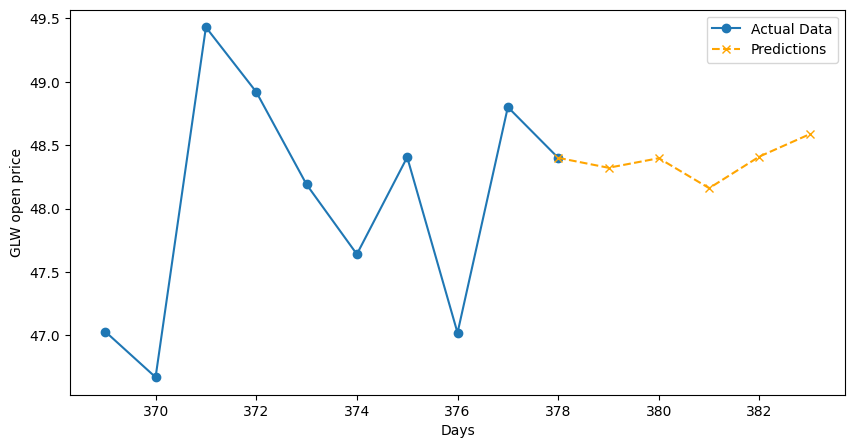

In [169]:
# Initialize the scaler and model
prediction_days = 5
scaler = StandardScaler()
# Most accurate model from earlier
model = LinearRegression(fit_intercept=True)

train_scaled = scaler.fit_transform(lin_df.drop(columns=[pred_stock]))
train_scaled = pd.DataFrame(train_scaled, columns=lin_df.drop(columns=[pred_stock]).columns)
train_scaled[pred_stock] = lin_df[pred_stock].values

model.fit(train_scaled.drop(columns=[pred_stock]), train_scaled[pred_stock])

last_known_data = lin_df.iloc[-prediction_days:].drop(columns=[pred_stock])
last_known_data_scaled = scaler.transform(last_known_data)

# Predict future values
future_predictions = pd.Series(model.predict(last_known_data_scaled))

pred_days_data = pd.concat([lin_df['o_GLW'], future_predictions], ignore_index=True)


plt.figure(figsize=(10, 5))
plt.plot(pred_days_data.index[-15:-prediction_days], pred_days_data.values[-15:-prediction_days], marker='o', label='Actual Data')
plt.plot(pred_days_data.index[-prediction_days - 1:], pred_days_data.values[-prediction_days - 1:], marker='x', linestyle='--', color='orange', label='Predictions')

plt.xlabel('Days')
plt.ylabel('GLW open price')
plt.legend()

# Show the plot
plt.show()

## <a class="anchor" id="omm">Part XVII : Optimal model and metrics</a>

In [170]:
results_df = pd.DataFrame(columns=['column', 'avg_mse', 'avg_mae', 'avg_r2'])

# Loop through each to find the best predictors 
for i in stock_prices_model_df.drop(pred_stock, axis=1).columns:
    results_linear_regression = evaluate_model_for_windows(models['linear_regression'], stock_prices_model_df[[i, pred_stock]], pred_stock, total_windows)

    avg_mse = np.mean([m['mse'] for m in results_linear_regression])
    avg_mae = np.mean([m['mae'] for m in results_linear_regression])
    avg_r2 = np.mean([m['r2'] for m in results_linear_regression])

    new_row = pd.DataFrame({'column': [i], 'avg_mse': [avg_mse], 'avg_mae': [avg_mae], 'avg_r2': [avg_r2]})
    results_df = pd.concat([results_df, new_row], ignore_index=True)

|██████████████████████████████████████████████████| 100.0% Complete
|██████████████------------------------------------| 28.6% Complete

C:\Users\benedict.grant\AppData\Local\Temp\ipykernel_30984\2212992063.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, new_row], ignore_index=True)


|██████████████████████████████████████████████████| 100.0% Complete
|██████████████████████████████████████████████████| 100.0% Complete
|██████████████████████████████████████████████████| 100.0% Complete
|██████████████████████████████████████████████████| 100.0% Complete
|██████████████████████████████████████████████████| 100.0% Complete
|██████████████████████████████████████████████████| 100.0% Complete
|██████████████████████████████████████████████████| 100.0% Complete
|██████████████████████████████████████████████████| 100.0% Complete
|██████████████████████████████████████████████████| 100.0% Complete
|██████████████████████████████████████████████████| 100.0% Complete
|██████████████████████████████████████████████████| 100.0% Complete
|██████████████████████████████████████████████████| 100.0% Complete
|██████████████████████████████████████████████████| 100.0% Complete
|██████████████████████████████████████████████████| 100.0% Complete


In [171]:
# Loss aversion creates more accurate prediction for pct change as shorter time periods 
results_df

,column,avg_mse,avg_mae,avg_r2
0,o_GLW_std,25.608470,4.083295,-198.614326
1,o_GLW_no_dev,3.285297,0.858683,-79.544468
2,Competitor_PCA_1,40.602310,5.247836,-402.833120
3,Competitor_PCA_2,40.753817,5.297432,-430.537520
4,Competitor_PCA_3,47.282711,5.711851,-456.295798
5,o_GLW_1_day_pct_chng,47.833551,5.756078,-458.228107
6,o_GLW_5_day_pct_chng,48.797396,5.832155,-481.460461
7,o_GLW_10_day_pct_chng,49.500973,5.904446,-516.777796
8,o_GLW_20_day_pct_chng,49.937149,6.050438,-486.690203
9,loss_averse_o_GLW_1_day_pct_chng,47.742829,5.749682,-459.043725


In [181]:
# Final metrics 
lin_df.columns

Index(['o_GLW', 'o_GLW_std', 'o_GLW_1_day_pct_chng', 'o_GLW_5_day_pct_chng',
       'o_GLW_10_day_pct_chng', 'o_GLW_20_day_pct_chng',
       'loss_averse_o_GLW_1_day_pct_chng', 'loss_averse_o_GLW_5_day_pct_chng',
       'loss_averse_o_GLW_10_day_pct_chng',
       'loss_averse_o_GLW_20_day_pct_chng', 'o_GLW_EMA', 'o_GLW_std_price'],
      dtype='object')

## <a class="anchor" id="fn">Part XIX : Final notes</a>

- **Model performance**: Given the model performs better than EMA, which in turn is more accurate than MA, we can conclude that the model predicts stock price movements better than MA, which is an industry standard.
- **Metrics dropped**: Competitor metrics and minimal deviation stock prices were dropped from the data most likely due to the model focusing too much on competitor movements being followed too closely and multicollinearity respectively.
- **Metrics chosen**: EMA and price-dependent STD showed the greatest accuracy, and removing pct change and pct change including loss aversion decreased the accuracy of the model, so the market is not completely rational and does take into account loss aversion.
- **Model chosen**: Linear regression showed the greatest accuracy most likely due to other models overfitting from the small amount of data available, with linear regression having a greater variance from training.
- **Data limitations**: polygon.io only allows 2 years of data and 5 competitors, so minimal data was available to train the model. A greater length of time would allow seasonality and anomaly investigation at a greater granularity.
- **Moving forward**: A greater time span and deviation in price movements from competitor changes will be investigated further. This would also allow more complex models and changes in the activation functions for different models to account for things like loss aversion and anchoring. This may also require more computational power and cost outside of the scope of this model.

## References 
- https://polygon.io/ - used to pull in stock prices 
- https://www.marketbeat.com/stocks/NYSE/GLW/competitors-and-alternatives/#:~:text=The%20main%20competitors%20of%20Corning,%2C%20and%20ARM%20(ARM). - Corning competitors